$$
  -\Delta u(x,y) \;=\; f(x,y),
  \qquad (x,y)\in[a,a+L]\times[b,b+L],
$$
$$
a=-1,\quad b=-1,\quad L=2
$$
$$
  u(x,y) = u_E(x,y) \quad\text{en las fronteras } x=a\ \cup\ y=b+L,
  \quad u_E(x,y) = \sin(\pi x)\cos(\pi y).
$$
$$
  \frac{\partial u}{\partial n}(x,y) = q_E(y)\quad\text{en } x=a+L,
  \qquad
  \frac{\partial u}{\partial n}(x,y) = q_S(x)\quad\text{en } y=b,
$$
$$
  q_E(y) = \pi\cos\bigl(\pi(a+L)\bigr)\cos(\pi y),
  \qquad
  q_S(x) = \pi\sin(\pi x)\sin\bigl(\pi b\bigr).
$$
$$
  f(x,y) = 2\pi^2\,\sin(\pi x)\cos(\pi y).
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
# =============
# DEFINICION DEL MODELO

def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True)
    return grads

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

# Parametros fisicos y de entrenamiento
a, b, Lx, Ly = 0, 0, torch.pi, 3*torch.pi/2
N_STEPS = 2500                     # iteraciones de entrenamiento
N_COLLOC = 25000                   # puntos collocation para PDE
N_BC = 25000                       # puntos para condiciones de frontera e iniciales

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definicion de la MLP para approximar Psi(x,y,t)
class POISSON(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, layers[0]),
            Sine(),
            *sum([[nn.Linear(layers[i], layers[i+1]), Sine()]
                  for i in range(len(layers)-1)], []),
            nn.Linear(layers[-1], 1)
        )
    def forward(self, x):
        return self.net(x)
    
# class POISSON(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.ReLU(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.ReLU()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)
# 
# class POISSON(nn.Module):
#     def __init__(self, layers):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(2, layers[0]),
#             nn.Tanh(),
#             *sum([[nn.Linear(layers[i], layers[i+1]), nn.Tanh()]
#                   for i in range(len(layers)-1)], []),
#             nn.Linear(layers[-1], 1)
#         )
#     def forward(self, x):
#         return self.net(x)

# Inicializar red, optimizador y scheduler
mlp = POISSON([50,50,50,50,50,50,50,50]).to(device)
mse = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                milestones=[2500, 5000, 7500, 10000, 20000], gamma=0.25)

print(f"Modelo inicializado correctamente en {device}.")

Modelo inicializado correctamente en cuda.


In [3]:
# Parametros
EXTRA_EPOCHS = 0
lambda_D    = 100
lambda_N    = 100
# lambda_D    = 1
# lambda_N    = 1
model_path   = 'models/poisson/lambdas/poisson'
os.makedirs(model_path, exist_ok=True)

# Funciones exactas
def u_exact(x, y):
    return torch.sin(x) * torch.sin(y)

def f_source(x, y):
    return 2 * torch.sin(x) * torch.sin(y)

def q_S(x):
    return -torch.sin(x)

# Carga de checkpoint previo
if os.path.exists(f"{model_path}.pth"):
    ckpt = torch.load(f"{model_path}.pth", map_location=device)
    mlp.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch   = ckpt['epoch']
    print(f"Cargado checkpoint de la época {start_epoch-1:02d}.")
else:
    start_epoch   = 1
    print("No hay checkpoint previo. Empezando desde epoch 01.")

N_EPOCHS = start_epoch + EXTRA_EPOCHS

for epoch in range(start_epoch, N_EPOCHS):
    mlp.train()
    epoch_loss = 0.0

    # Bucle con tqdm
    loop = tqdm(range(1, N_STEPS+1),
                desc=f"Epoch {epoch:02d}",
                unit="step",
                delay=0.1,
                total=N_STEPS)

    for step in loop:
        mlp.train()
        loss_total = 0.0

        # Residuo PDE
        xy_pde = torch.rand(N_COLLOC, 2, device=device)
        xy_pde[:,0] = a + xy_pde[:,0] * Lx
        xy_pde[:,1] = b + xy_pde[:,1] * Ly
        xy_pde.requires_grad_(True)

        u_pred = mlp(xy_pde).squeeze()
        grads = computeGrads(u_pred, xy_pde)
        u_x, u_y = grads[:,0], grads[:,1]
        u_xx = computeGrads(u_x, xy_pde)[:,0]
        u_yy = computeGrads(u_y, xy_pde)[:,1]
        lap_u = u_xx + u_yy

        f_val = f_source(xy_pde[:,0], xy_pde[:,1]).to(device)
        loss_pde = mse(-lap_u - f_val, torch.zeros_like(lap_u))

        # Dirichlet en x=a y=b+Ly x=a+Lx
        xb1_D = torch.zeros(N_BC,1,device=device) + a
        yb1_D = b + torch.rand(N_BC,1,device=device)*Ly
        pts_D1 = torch.cat([xb1_D, yb1_D], dim=1)

        xb2_D = a + torch.rand(N_BC,1,device=device)*Lx
        yb2_D = torch.zeros(N_BC,1,device=device) + (b+Ly)
        pts_D2 = torch.cat([xb2_D, yb2_D], dim=1)

        xb3_D = torch.zeros(N_BC,1,device=device) + a + Lx
        yb3_D = b + torch.rand(N_BC,1,device=device)*Ly
        pts_D3 = torch.cat([xb3_D, yb3_D], dim=1)

        u_D1 = mlp(pts_D1).squeeze()
        u_D2 = mlp(pts_D2).squeeze()
        u_D3 = mlp(pts_D3).squeeze()
        uE1 = u_exact(pts_D1[:,0], pts_D1[:,1]).to(device)
        uE2 = u_exact(pts_D2[:,0], pts_D2[:,1]).to(device)
        uE3 = u_exact(pts_D3[:,0], pts_D3[:,1]).to(device)
        loss_D = lambda_D*(mse(u_D1, uE1) + mse(u_D2, uE2) + mse(u_D3, uE3))

        # Neumann en y=b
        xb_N = a + torch.rand(N_BC,1,device=device)*Lx
        yb_N = torch.zeros(N_BC,1,device=device) + b
        pts_N = torch.cat([xb_N, yb_N], dim=1)

        # derivada normal en y=b es ∂/∂y
        pts_N.requires_grad_(True)
        uN = mlp(pts_N).squeeze()
        uy_N = computeGrads(uN, pts_N)[:,1]
        qS_val = q_S(pts_N[:,0]).to(device)
        loss_N = mse(uy_N, qS_val)

        loss_N = lambda_N*loss_N

        # Optimizacion
        loss = loss_pde + loss_D + loss_N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        # Mostrar metricas en la barra
        loop.set_postfix({
            "pde": f"{loss_pde.item():.2e}",
            "D": f"{loss_D.item():.2e}",
            "N":  f"{loss_N.item():.2e}"
        })

    # Promedio de loss de la epoch
    avg_epoch_loss = epoch_loss / N_STEPS
    print(f"Epoch {epoch:02d} concluida — avg loss: {avg_epoch_loss:.3e}")

    # Guardar checkpoint de la epoca
    checkpoint_path = f"{model_path}_{epoch:02d}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_pde': loss_pde,
        'loss_pde': loss_D/lambda_D,
        'loss_bc': loss_N/lambda_N
    }, checkpoint_path)

    # Guardar checkpoint general
    checkpoint_path = f"{model_path}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

print("Entrenamiento completado.")

Cargado checkpoint de la época 10.
Entrenamiento completado.


In [4]:
import numpy as n
print(n.cos(3*n.pi / 2))

-1.8369701987210297e-16


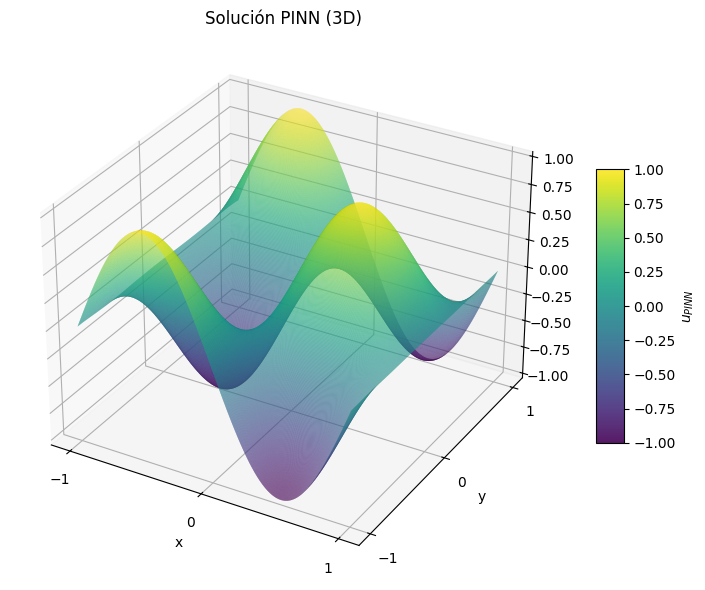

In [5]:
# =============
# REPRESENTACION DE LA SOLUCION MLP

def visualize_poisson(model, Nx=200, Ny=200):
    """
    Visualiza la solución aproximada del MLP al problema de Poisson,
    incluyendo un gráfico 3D de la superficie u(x,y).
    """
    model.eval()
    model.cpu()

    # Parametros del dominio
    a, b, L = -1.0, -1.0, 2.0

    # 1. Generación de la malla en [a,a+L]×[b,b+L]
    x = np.linspace(a, a+L, Nx)
    y = np.linspace(b, b+L, Ny)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    inp = torch.from_numpy(XY).float().requires_grad_(True)

    # Predicción de u aproximado
    with torch.no_grad():
        u_pred = model(inp).squeeze().cpu().numpy().reshape(Ny, Nx)

    # Grafica 3D de la superficie u_pred
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # ticks para ejes
    xticks = [a, a + L/2, a + L]
    yticks = [b, b + L/2, b + L]

    # plot_surface
    surf = ax.plot_surface(
        X, Y, u_pred,
        rstride=3, cstride=3,
        cmap='viridis', edgecolor='none', alpha=0.9
    )

    ax.set_title('Solución PINN (3D)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='$u_{PINN}$')

    plt.tight_layout()
    plt.show()

visualize_poisson(mlp, Nx=2000, Ny=2000)

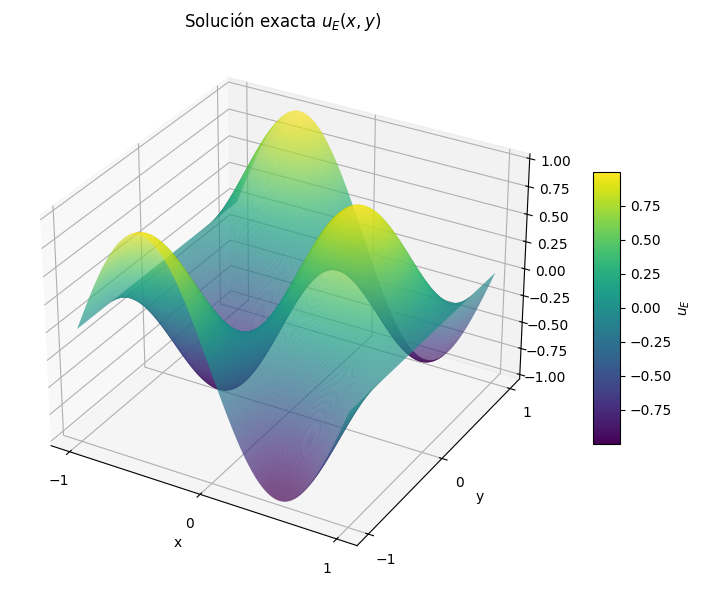

In [6]:
# =============
# REPRESENTACION DE LA SOLUCION EXACTA

# Parametros del dominio y malla
a, b, L = -1.0, -1.0, 2.0
N = 2000
x = np.linspace(a, a + L, N + 2)
y = np.linspace(b, b + L, N + 2)
X, Y = np.meshgrid(x, y, indexing='ij')

# Funcion exacta
def uE(x, y):
    return np.sin(np.pi * x) * np.cos(np.pi * y)

# Preparacion de ticks
xticks = [a, a + L/2, a + L]
yticks = [b, b + L/2, b + L]

# Visualizacion 3D sin subplots
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')  # unico eje 3D

surf = ax.plot_surface(
    X, Y, uE(X, Y),
    cmap='viridis', rstride=3, cstride=3
)

ax.set_title('Solución exacta $u_E(x,y)$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.set_label('$u_E$')

plt.tight_layout()
plt.show()